## import the necessary python packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import qiskit
from qiskit import QuantumCircuit
from qiskit_aer import Aer, AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise.errors.standard_errors import (
    depolarizing_error,
)

from mitiq.zne import mitigate_executor
from mitiq.zne.inference import RichardsonFactory

define the hamiltonian and the ansatz circuit 

In [2]:
from qiskit.quantum_info import SparsePauliOp
import numpy as np
 
def to_qiskit(H):
    coeff_list = []
    op_list = []
    for coeff, op in zip(H.coeffs, H.ops):
        coeff_list.append(coeff.real)
        op_list.append(str(qml.pauli.pauli_word_to_string(op, wire_map=[0,1,2,3])))
    return SparsePauliOp(op_list, coeffs=np.array(coeff_list))

import pennylane as qml

from openfermion import *
from openfermion.transforms import jordan_wigner
from openfermion.utils import load_operator
n_site = 2
n_qubits = 2 * n_site
H_openfermion = load_operator(
    file_name=f"{n_qubits}_qubits_H",
    data_directory="./hamiltonian",
    plain_text=False,
)
H_openfermion_jw = jordan_wigner(H_openfermion)
H_qiskit= transforms.qubit_operator_to_pauli_sum(H_openfermion_jw)
H_pennylane = qml.import_operator(H_openfermion_jw)
H = to_qiskit(H_pennylane)
singles =[[0, 2]]
doubles = [[0, 1, 2, 3]]


from qiskit import QuantumCircuit, QuantumRegister

def full_double_excitation_decomposition(params, wires):
    qr = QuantumRegister(4, name="q")
    qc = QuantumCircuit(qr)

    qc.cx(wires[2], wires[3])
    qc.cx(wires[0], wires[2])
    qc.h(wires[0])
    qc.h(wires[3])
    qc.cx(wires[0], wires[1])
    qc.cx(wires[2], wires[3])
    qc.ry(-params / 8, wires[0])
    qc.ry(params / 8, wires[1])
    qc.cx(wires[0], wires[3])
    qc.h(wires[3])
    qc.cx(wires[3], wires[1])
    qc.ry(-params / 8, wires[0])
    qc.ry(params / 8, wires[1])
    qc.cx(wires[2], wires[1])
    qc.cx(wires[2], wires[0])
    qc.ry(params / 8, wires[0])
    qc.ry(-params / 8, wires[1])
    qc.cx(wires[3], wires[1])
    qc.h(wires[3])
    qc.cx(wires[0], wires[3])
    qc.ry(params / 8, wires[0])
    qc.ry(-params / 8, wires[1])
    qc.cx(wires[0], wires[1])
    qc.cx(wires[2], wires[0])
    qc.h(wires[0])
    qc.h(wires[3])
    qc.cx(wires[0], wires[2])
    qc.cx(wires[2], wires[3])

    return qc

def full_single_excitation_decomposition(params, wires):
    qr = QuantumRegister(4, name="q")
    qc = QuantumCircuit(qr)

    qc.cx(wires[0], wires[1])
    qc.ry(params / 2, wires[0])
    qc.cx(wires[1], wires[0])
    qc.ry(-params / 2, wires[0])
    qc.cx(wires[1], wires[0])
    qc.cx(wires[0], wires[1])

    return qc
def circuit(params):
    qr = QuantumRegister(n_qubits, name="q")
    qc = QuantumCircuit(qr)
    # Define the qubits with the given initial state
    initial_state = [1, 1, 0, 0]
    # Apply X-gates to initialize the qubits
    for i, bit in enumerate(initial_state):
        if bit == 1:
            qc.x(qr[i])
    i = 0
    for excitation in doubles:
        qc.compose(full_double_excitation_decomposition(params[i], excitation), inplace=True)
        i += 1
    for excitation in singles:
        qc.compose(full_single_excitation_decomposition(params[i], excitation), inplace=True)
        i += 1
    return qc

define the noisy estimator of the expectation value and the noise model

In [3]:
# observable to measure
hamiltonian = H.to_matrix()

# strength of noise channel
noise_level = 0.01

def executor_with_noise(circuit: QuantumCircuit) -> float:
    """Simulates the execution of a circuit with depolarizing noise.

    Args:
        circuit: The input circuit.

    Returns:
        The expectation value of the hamiltonian.
    """
    # avoid mutating the input circuit
    circ = circuit.copy()
    circ.save_density_matrix()
    
    # Initialize qiskit noise model. In this case a depolarizing
    # noise model with the same noise strength on all gates
    #noise_model = NoiseModel()
    #noise_model.add_all_qubit_quantum_error(
    #    depolarizing_error(noise_level, 1), ["rx"]
    #)
    #noise_model.add_all_qubit_quantum_error(
    #    depolarizing_error(noise_level, 2), ["cx"]
    #) 
    from qiskit_ibm_runtime.fake_provider import FakeLima
    from qiskit_aer.noise import NoiseModel

    device = FakeLima()
    noise_model = NoiseModel.from_backend(device)
    #execute experiment with depolarizing noise
    job = qiskit.execute(
        experiments=circ,
        backend=AerSimulator(method="density_matrix",noise_model=noise_model, shots = 1000 ),
        #noise_model=noise_model,
        basis_gates=noise_model.basis_gates + ["save_density_matrix"],
        # we want all gates to be actually applied,
        # so we skip any circuit optimization 
        optimization_level=0,
        #shots = 10,
        approximation = False,
    )
    rho = job.result().data()["density_matrix"]
    expectation = np.real(np.trace(rho @ hamiltonian))
    return expectation 

In [4]:
params = [9, 1]
print(noiseless_executor(circuit(params)))
print(executor_with_noise(circuit(params)))

NameError: name 'noiseless_executor' is not defined

In [5]:
from mitiq import zne
from mitiq.zne.scaling import fold_global

fac = RichardsonFactory(scale_factors=[1.0, 2.0, 3.0])
mitigated = zne.execute_with_zne(circuit(params), executor_with_noise, factory=fac, scale_noise = fold_global)
print(mitigated)


-3.4471477417889225


In [6]:
# define callback
# note: Re-run this cell to restart lists before training
counts_mitigated = []
values_mitigated = []


def store_intermediate_result_mitigated(eval_count, parameters, mean, std):
    counts_mitigated.append(eval_count)
    values_mitigated.append(mean)

define the mitigation technique and to the VQE optimization

In [7]:
mitigated_energies = []
def callback_mitigated(params):
    # Evaluate the current mitigated energy and append it to the list
    energy = objective_function_mitigated(params)
    mitigated_energies.append(energy)
    print(f"Current parameters: {params}, mitigated Energy: {energy}")

In [9]:
from mitiq import zne
from mitiq.zne.scaling import fold_global
from scipy.optimize import minimize

def objective_function_mitigated(params):


    # Evaluate the extrapolation
    expectation_value_mitigated = zne.execute_with_zne(circuit(params), executor_with_noise, factory=fac, scale_noise= fold_global)
    return expectation_value_mitigated
 
# Gradient descent optimizer setup, optimization execution remains unchanged
params = np.zeros(len(doubles + singles))  # Initial parameter setup
#from qiskit.algorithms.optimizers import GradientDescent
#optimizer = GradientDescent(maxiter=100, learning_rate=0.1, callback=store_intermediate_result_mitigated)
# Execute VQE optimization

#GRADIENT OF QISKIT
#from qiskit_algorithms.optimizers import GradientDescent
#optimizer = GradientDescent(maxiter=100, learning_rate=0.5, callback=store_intermediate_result_mitigated)
#result = optimizer.minimize(fun=objective_function, x0=params)
#print(f"Found minimum {result.x} at a value of {result.fun} using {result.nfev} evaluations.")

#GRADIENT OF SCIPY
result_mitigated = minimize(fun=objective_function_mitigated, x0=params, method='COBYLA', options={'maxiter': 300}, callback=callback_mitigated)
print(f"Found minimum {result_mitigated.x} at a value of {result_mitigated.fun} using {result_mitigated.nfev} evaluations.")




Current parameters: [1. 0.], mitigated Energy: -1.6703998722759703
Current parameters: [1. 1.], mitigated Energy: -1.915994142402146
Current parameters: [1.99331781 1.11541115], mitigated Energy: -3.3891103804493214
Current parameters: [2.97936001 1.28190671], mitigated Energy: -2.957739294343572
Current parameters: [2.48633891 1.19865893], mitigated Energy: -3.4242813976483286
Current parameters: [2.44471502 1.44516948], mitigated Energy: -3.2649076679907987
Current parameters: [2.62315692 0.71774227], mitigated Energy: -3.677504869613219
Current parameters: [2.77404622 0.24105326], mitigated Energy: -3.7794524100842732
Current parameters: [3.26302633 0.1366576 ], mitigated Energy: -3.2084776822319148
Current parameters: [2.32344055 0.02436331], mitigated Energy: -3.8650790588508155
Current parameters: [ 2.17184872 -0.45210276], mitigated Energy: -3.723026007245665
Current parameters: [2.15321447 0.20745641], mitigated Energy: -3.7506034066489944
Current parameters: [ 2.34052511 -0.09

ideal simulation

In [16]:
def noiseless_executor(circuit: QuantumCircuit) -> float:
    """Simulates the execution of a circuit without noise.

    Args:
        circuit: The input circuit.

    Returns:
        The expectation value of the  observable.
    """
    # avoid mutating the input circuit
    circ = circuit.copy()
    circ.save_density_matrix()

    # execute experiment without noise
    job = qiskit.execute_function.execute(
        experiments=circ,
        backend=AerSimulator(method="density_matrix"),
        noise_model=None,
        # we want all gates to be actually applied,
        # so we skip any circuit optimization 
        optimization_level=0,
        shots=1000,
    )
    rho = job.result().data()["density_matrix"]

    expectation = np.real(np.trace(rho @ hamiltonian))
    return expectation 

In [17]:
free_energies = []
def callback_free(params):
    # Evaluate the current mitigated energy and append it to the list
    energy = objective_function_free(params)
    free_energies.append(energy)
    print(f"Current parameters: {params},' free Energy: {energy}")

In [18]:
def objective_function_free(params):
    # Evaluate the extrapolation
    expectation_value = noiseless_executor(circuit(params))
    return expectation_value
params = np.zeros(len(doubles + singles))  # Initial parameter setup
 
# Execute VQE optimization
from qiskit_algorithms.optimizers import GradientDescent
#optimizer = GradientDescent(maxiter=100, learning_rate=0.5, callback=store_intermediate_result_noisy)
#GRADIENT OF SCIPY
result_noisy = minimize(fun=objective_function_free, x0=params, method='COBYLA', options={'maxiter': 300}, callback=callback_free)
#
print(f"Found minimum {result_noisy.x} at a value of {result_noisy.fun} using {result_noisy.nfev} evaluations.")

Current parameters: [1. 0.],' free Energy: -1.6815967695203453
Current parameters: [1. 1.],' free Energy: -1.9315673370597315
Current parameters: [1.99349948 1.11383663],' free Energy: -3.4602741964780472
Current parameters: [2.98007369 1.27715023],' free Energy: -3.0269357830370476
Current parameters: [2.48678659 1.19549343],' free Energy: -3.5028292066689346
Current parameters: [2.44595819 1.44213698],' free Energy: -3.3342959623131985
Current parameters: [2.62958784 0.71631935],' free Energy: -3.7669020111788423
Current parameters: [2.78961944 0.24262125],' free Energy: -3.8674396412193
Current parameters: [3.28469886 0.17264722],' free Energy: -3.2512861864352494
Current parameters: [2.34176359 0.02030361],' free Energy: -3.9693674304188606
Current parameters: [ 2.14706456 -0.44023117],' free Energy: -3.7959277205932853
Current parameters: [2.17695309 0.20828633],' free Energy: -3.859957625135449
Current parameters: [2.46628506 0.03123078],' free Energy: -3.998355144444285
Current 

execute the noisy simulation within the noisy device

In [14]:
noisy_energies = []
def callback_noisy(params):
    # Evaluate the current mitigated energy and append it to the list
    energy = objective_function_noisy(params)
    noisy_energies.append(energy)
    print(f"Current parameters: {params},' unmitigated Energy: {energy}")

In [15]:
from mitiq import zne
from mitiq.zne.scaling import fold_global
from scipy.optimize import minimize

def objective_function_noisy(params):
    # Evaluate the extrapolation
    expectation_value = executor_with_noise(circuit(params))
    return expectation_value
params = np.zeros(len(doubles + singles))  # Initial parameter setup
 
# Execute VQE optimization
from qiskit_algorithms.optimizers import GradientDescent
#optimizer = GradientDescent(maxiter=100, learning_rate=0.5, callback=store_intermediate_result_noisy)
#GRADIENT OF SCIPY
result_noisy = minimize(fun=objective_function_noisy, x0=params, method='COBYLA', options={'maxiter': 300}, callback=callback)
#
print(f"Found minimum {result_noisy.x} at a value of {result_noisy.fun} using {result_noisy.nfev} evaluations.")
## GRADIENT OF QISKIT
#result = optimizer.minimize(fun=objective_function, x0=params) 
#print(f"Found minimum {result.x} at a value of {result.fun} using {result.nfev} evaluations.")

Current parameters: [1. 0.],' unmitigated Energy: -1.6652210635367568
Current parameters: [1. 1.],' unmitigated Energy: -1.9037832772012702
Current parameters: [1.99334529 1.11517433],' unmitigated Energy: -3.348734507141218
Current parameters: [2.97965686 1.28006672],' unmitigated Energy: -2.942320550081694
Current parameters: [2.48650108 1.19762053],' unmitigated Energy: -3.390228154402248
Current parameters: [2.44527798 1.44419842],' unmitigated Energy: -3.231652401836884
Current parameters: [2.63222605 0.71932749],' unmitigated Energy: -3.6378777498366546
Current parameters: [2.79607658 0.24693676],' unmitigated Energy: -3.7301890315399353
Current parameters: [3.29274949 0.18935187],' unmitigated Energy: -3.1395824427607693
Current parameters: [2.34915468 0.02274752],' unmitigated Energy: -3.832040492252594
Current parameters: [ 2.1352952  -0.42920837],' unmitigated Energy: -3.658041458359317
Current parameters: [2.18676963 0.21282933],' unmitigated Energy: -3.7320659216641356
Curr

In [27]:
print(min(noisy_energies))

-3.899870003945685


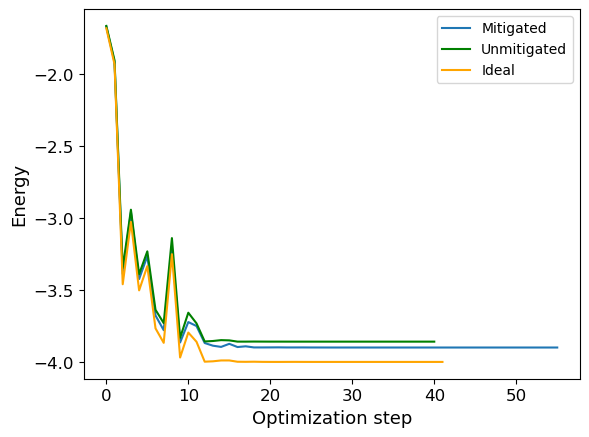

In [19]:
import matplotlib.pyplot as plt
plt.plot(range(len(mitigated_energies)),mitigated_energies, label ='Mitigated', )
plt.plot(range(len(noisy_energies)),noisy_energies, label ='Unmitigated', color = 'green')
plt.plot(range(len(free_energies)),free_energies, label ='Ideal', color = 'orange')
plt.xlabel("Optimization step", fontsize=13)
plt.ylabel("Energy", fontsize=13)
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [29]:
'''import pylab

pylab.rcParams["figure.figsize"] = (12, 4)
#pylab.plot(range(len(values)), values)
#pylab.plot(counts_mitigated, values_mitigated)
#pylab.plot(counts_noiseless, values_noiseless, label ='Noiseless')
pylab.plot(counts_noisy, values_noisy,label ='Noisy')
pylab.legend()
pylab.xlabel("Eval count")
pylab.ylabel("Energy")'''

'import pylab\n\npylab.rcParams["figure.figsize"] = (12, 4)\n#pylab.plot(range(len(values)), values)\n#pylab.plot(counts_mitigated, values_mitigated)\n#pylab.plot(counts_noiseless, values_noiseless, label =\'Noiseless\')\npylab.plot(counts_noisy, values_noisy,label =\'Noisy\')\npylab.legend()\npylab.xlabel("Eval count")\npylab.ylabel("Energy")'